In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)
from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3

import numpy as np
import scipy as sp
import astropy.units as u
from astropy.constants import c

In [2]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.468, -1.178, -2.117]  # Slopes for initial mass function
nbin12 = [5, 5, 20]

# Output times for the evolution
tout = np.array([11000])

# Integration settings
N0 = 5e5  # Normalization of stars
Ndot = -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [3]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=100,
)

/home/peter/research/ssptools/ssptools/evolve_mf_3.py:321: RuntimeWarning: divide by zero encountered in true_divide
  As = Ns / P1
/home/peter/research/ssptools/ssptools/evolve_mf_3.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  Aj = Nj / self.Pk(alphaj, 1, m1, mto)


In [4]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])

In [5]:
print(mj[:nms])

[0.11851084 0.16351292 0.22560363 0.31127202 0.42947124 0.53616312
 0.6158897  0.70747148 0.80754321]


In [6]:
print("mj  | q: 0.5 \t 0.75 \t 0.95")
print("-------------------------------")
for i in range(nms):
    print(f"{mj[i]:.2f} \t {mj[i]*0.5:.3f} \t {mj[i]*0.75:.3f} \t {mj[i]*0.95:.3f}")

mj  | q: 0.5 	 0.75 	 0.95
-------------------------------
0.12 	 0.059 	 0.089 	 0.113
0.16 	 0.082 	 0.123 	 0.155
0.23 	 0.113 	 0.169 	 0.214
0.31 	 0.156 	 0.233 	 0.296
0.43 	 0.215 	 0.322 	 0.408
0.54 	 0.268 	 0.402 	 0.509
0.62 	 0.308 	 0.462 	 0.585
0.71 	 0.354 	 0.531 	 0.672
0.81 	 0.404 	 0.606 	 0.767


In [7]:
class BinaryShift:
    def __init__(self, fb, q):
        self.fb = fb
        self.q = q

    def dump(self):
        print(f"{self.fb = }")
        print(f"{self.q = }")

    def shift(self, mj, Mj, nms):
        # dont mess with original
        mj = mj.copy()
        Mj = Mj.copy()

        # loop through the mass bins
        for i in range(nms):
            print()
            print(f"current mj: {mj[i]:.3f}")
            # get mass of companion
            companion_mass = mj[i] * self.q
            print(f"{companion_mass = :.3f}")
            # mass of new bin
            mj_bin = mj[i] + companion_mass
            print(f"new mass: {mj_bin:.3f} ")
            # if the companion is smaller than the lightest MS bin, just skip it
            if companion_mass < np.min(mj):
                print(
                    f"companion mass {companion_mass:.3f} smaller than {np.min(mj):.3f}, skipping"
                )
                pass
            else:
                # total mass in binaries for this new bin
                Mj_bin = Mj[i] * self.fb
                print(f"total mass in binaries {Mj_bin:.3f}")
                # add in the new mean mass bin
                mj = np.append(mj, mj_bin)
                # add in the new total mass bin
                Mj = np.append(Mj, Mj_bin)
                # remove the mass from the old total mass bin
                Mj[i] -= Mj_bin
        return mj, Mj

In [8]:
bs = BinaryShift(q=1, fb=0.3)

In [9]:
bs.dump()

self.fb = 0.3
self.q = 1


In [10]:
mj_new, Mj_new = bs.shift(mj=mj, Mj=Mj, nms=nms)


current mj: 0.119
companion_mass = 0.119
new mass: 0.237 
companion mass 0.119 smaller than 0.119, skipping

current mj: 0.164
companion_mass = 0.164
new mass: 0.327 
total mass in binaries 1722.521

current mj: 0.226
companion_mass = 0.226
new mass: 0.451 
total mass in binaries 2820.519

current mj: 0.311
companion_mass = 0.311
new mass: 0.623 
total mass in binaries 4618.422

current mj: 0.429
companion_mass = 0.429
new mass: 0.859 
total mass in binaries 7562.377

current mj: 0.536
companion_mass = 0.536
new mass: 1.072 
total mass in binaries 4369.985

current mj: 0.616
companion_mass = 0.616
new mass: 1.232 
total mass in binaries 4897.444

current mj: 0.707
companion_mass = 0.707
new mass: 1.415 
total mass in binaries 5488.566

current mj: 0.808
companion_mass = 0.808
new mass: 1.615 
total mass in binaries 5568.010


In [11]:
mj

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])

In [12]:
mj_new

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993, 0.32702584, 0.45120725, 0.62254403, 0.85894247,
       1.07232625, 1.23177939, 1.41494296, 1.61508642])

(0.0, 2.0)

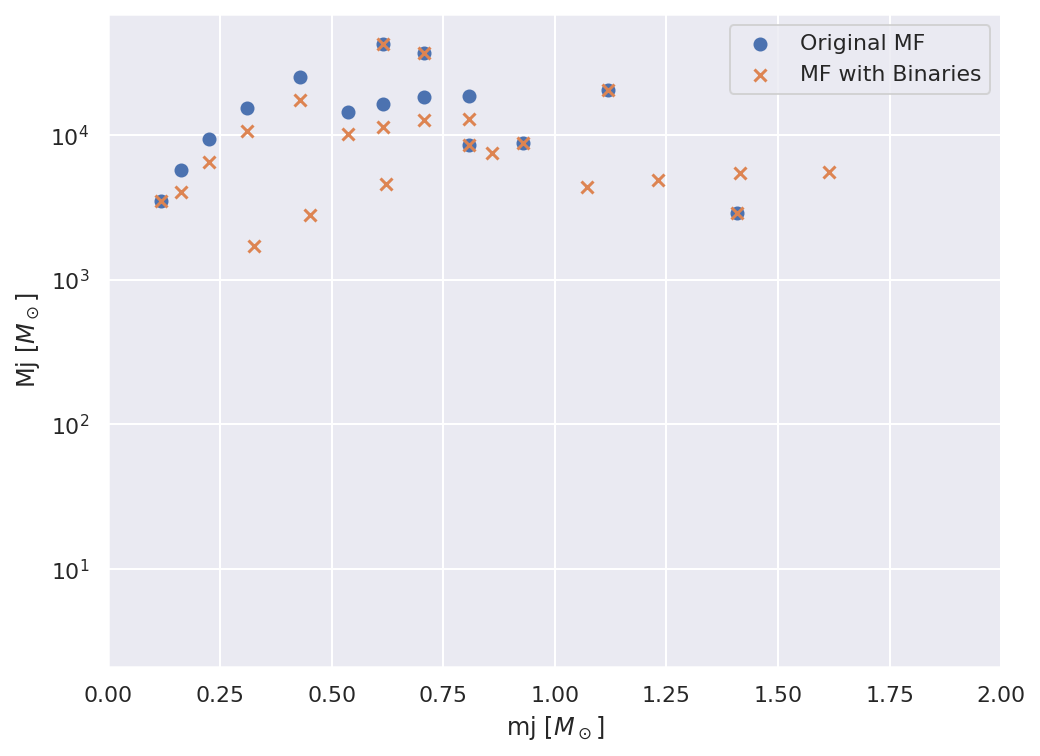

In [13]:
plt.figure()
plt.scatter(mj, Mj, label="Original MF")
plt.yscale("log")
plt.scatter(mj_new, Mj_new, label="MF with Binaries", marker="x")
plt.legend()
plt.ylabel(r"Mj [$M_\odot$]")
plt.xlabel(r"mj [$M_\odot$]")
plt.xlim(0, 2)

I think I'd like to switch to passing in the emf3 object and using that to determine the MS, WD bins instead of passing in nms

Next lets get this working with vlaues other than $q=1$